In [24]:
!pwd
import sys
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sys.executable

/c/Users/81908/jupyter_notebook/tf_2_work/Probspace_geme_compe/notebook


'C:\\Users\\81908\\Anaconda3\\envs\\tfgpu\\python.exe'

# スプラコンペ 勝率検証EDA
スプラトゥーン2を普段やっているので、ドメイン知識を使ってブキ/ルールごとの勝率の違いや強いと言われているスペシャルなどについて、いくつか検証をしてみました。参考になればと思います。  
特徴量として使用して精度が上がるかどうかの検証はしていません。  　　
また今回のデータは5.0.1環境でのものであり、今回のコンペティションで与えられたデータに限るもので、現環境での分析とは異なるものであることにご留意ください。  
- https://prob.space/competitions/game_winner/discussions/uratatsu-Post2240d51da94b313ed72c

In [25]:
from collections import Counter
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [26]:
ORIG_DIR = "../data/orig"

train = pd.read_csv(f'{ORIG_DIR}/train_data.csv')
test = pd.read_csv(f'{ORIG_DIR}/test_data.csv')
#https://prob.space/competitions/game_winner/discussions/e-toppo-Post0082a60376ef134af3a4
buki_data = pd.read_csv(f'{ORIG_DIR}/statink-weapon2.csv')

# カテゴリ名称を変更比較用
display(buki_data.loc[buki_data['category2'] == 'maneuver'].head(3))

# カテゴリ名称とブキ名称が被るためカテゴリ名称を変更する
buki_data.loc[buki_data['category2'] == 'maneuver', 'category2'] = 'maneuver_cat' 
display(buki_data.loc[buki_data['category2'] == 'maneuver_cat'].head(3))

,category1,category2,key,subweapon,special,mainweapon,reskin,splatnet,[de-DE],[en-GB],[en-US],[es-ES],[es-MX],[fr-CA],[fr-FR],[it-IT],[ja-JP],[nl-NL],[ru-RU]
47,shooter,maneuver,sputtery_clear,torpedo,chakuchi,sputtery,sputtery_clear,5002,Sprenkler Claro,Clear Dapple Dualies,Clear Dapple Dualies,Atomizador dual sencillo,Atomizador dual sencillo,Double moucheteur dépoli,Double moucheteur dépoli,Ripolpella duplo minimal,スパッタリークリア,Dubbelspatters Helder,Импрессиометы «Белизна»
48,shooter,maneuver,dualsweeper_custom,splashbomb,amefurashi,dualsweeper,dualsweeper_custom,5031,Dual-Platscher SE,Custom Dualie Squelchers,Custom Dualie Squelchers,Barredora dual SP,Soplador dual adaptado,Double nettoyeur modifié,Double nettoyeur modifié,Sweeper duplo CM,デュアルスイーパーカスタム,Gemodde Dubbelplonzers,Спурт-плескари «Понт»
49,shooter,maneuver,sputtery,jumpbeacon,kyubanbomb_pitcher,sputtery,sputtery,5000,Sprenkler,Dapple Dualies,Dapple Dualies,Atomizador dual,Atomizador dual,Double moucheteur,Double moucheteur,Ripolpella duplo,スパッタリー,Dubbelspatters,Импрессиометы


,category1,category2,key,subweapon,special,mainweapon,reskin,splatnet,[de-DE],[en-GB],[en-US],[es-ES],[es-MX],[fr-CA],[fr-FR],[it-IT],[ja-JP],[nl-NL],[ru-RU]
47,shooter,maneuver_cat,sputtery_clear,torpedo,chakuchi,sputtery,sputtery_clear,5002,Sprenkler Claro,Clear Dapple Dualies,Clear Dapple Dualies,Atomizador dual sencillo,Atomizador dual sencillo,Double moucheteur dépoli,Double moucheteur dépoli,Ripolpella duplo minimal,スパッタリークリア,Dubbelspatters Helder,Импрессиометы «Белизна»
48,shooter,maneuver_cat,dualsweeper_custom,splashbomb,amefurashi,dualsweeper,dualsweeper_custom,5031,Dual-Platscher SE,Custom Dualie Squelchers,Custom Dualie Squelchers,Barredora dual SP,Soplador dual adaptado,Double nettoyeur modifié,Double nettoyeur modifié,Sweeper duplo CM,デュアルスイーパーカスタム,Gemodde Dubbelplonzers,Спурт-плескари «Понт»
49,shooter,maneuver_cat,sputtery,jumpbeacon,kyubanbomb_pitcher,sputtery,sputtery,5000,Sprenkler,Dapple Dualies,Dapple Dualies,Atomizador dual,Atomizador dual,Double moucheteur,Double moucheteur,Ripolpella duplo,スパッタリー,Dubbelspatters,Импрессиометы


In [27]:
#https://prob.space/competitions/game_winner
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()  # マルチラベル形式でonehot化（複数列で1つく）
mlb.fit([set(train['A1-weapon'].unique())])
MultiLabelBinarizer(classes=None, sparse_output=False)

def trans_weapon(df, columns=['A1-weapon', 'A2-weapon', 'A3-weapon', 'A4-weapon']):
    """指定列をonehot化"""
    weapon = df.fillna('none') 
    weapon_binarized = mlb.transform(weapon[columns].values)
    return pd.DataFrame(weapon_binarized, columns=mlb.classes_)

def make_input_output(df, with_y=False):
    """各武器列をonehot化して結合"""
    a_weapon = trans_weapon(df, ['A1-weapon', 'A2-weapon', 'A3-weapon', 'A4-weapon'])
    b_weapon = trans_weapon(df, ['B1-weapon', 'B2-weapon', 'B3-weapon', 'B4-weapon'])
    a_weapon = a_weapon.add_suffix('_A')
    b_weapon = b_weapon.add_suffix('_B')
    X = pd.concat([a_weapon, b_weapon], axis=1)
    if with_y:
        y = df['y']
        return X, y
    return X

X = make_input_output(train, with_y=False)
train = pd.concat([train, X], axis=1)
train

,id,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,A2-weapon,A2-rank,A2-level,A3-weapon,A3-rank,A3-level,A4-weapon,A4-rank,A4-level,B1-weapon,B1-rank,B1-level,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level,y,52gal_A,52gal_becchu_A,52gal_deco_A,96gal_A,96gal_deco_A,bamboo14mk1_A,bamboo14mk2_A,bamboo14mk3_A,barrelspinner_A,barrelspinner_deco_A,barrelspinner_remix_A,bold_A,bold_7_A,bold_neo_A,bottlegeyser_A,bottlegeyser_foil_A,bucketslosher_A,bucketslosher_deco_A,bucketslosher_soda_A,campingshelter_A,campingshelter_camo_A,campingshelter_sorella_A,carbon_A,carbon_deco_A,clashblaster_A,clashblaster_neo_A,dualsweeper_A,dualsweeper_custom_A,dynamo_A,dynamo_becchu_A,dynamo_tesla_A,explosher_A,explosher_custom_A,furo_A,furo_deco_A,h3reelgun_A,h3reelgun_cherry_A,h3reelgun_d_A,heroblaster_replica_A,herobrush_replica_A,herocharger_replica_A,heromaneuver_replica_A,heroroller_replica_A,heroshelter_replica_A,heroshooter_replica_A,heroslosher_replica_A,herospinner_replica_A,hissen_A,hissen_hue_A,hokusai_A,hokusai_becchu_A,hokusai_hue_A,hotblaster_A,hotblaster_custom_A,hydra_A,hydra_custom_A,jetsweeper_A,jetsweeper_custom_A,kelvin525_A,kelvin525_becchu_A,kelvin525_deco_A,kugelschreiber_A,kugelschreiber_hue_A,l3reelgun_A,l3reelgun_becchu_A,l3reelgun_d_A,liter4k_A,liter4k_custom_A,liter4k_scope_A,liter4k_scope_custom_A,longblaster_A,longblaster_custom_A,longblaster_necro_A,maneuver_A,maneuver_becchu_A,maneuver_collabo_A,momiji_A,nautilus47_A,nautilus79_A,nova_A,nova_becchu_A,nova_neo_A,nzap83_A,nzap85_A,nzap89_A,ochiba_A,octoshooter_replica_A,pablo_A,pablo_hue_A,pablo_permanent_A,parashelter_A,parashelter_sorella_A,prime_A,prime_becchu_A,prime_collabo_A,promodeler_mg_A,promodeler_pg_A,promodeler_rg_A,quadhopper_black_A,quadhopper_white_A,rapid_A,rapid_becchu_A,rapid_deco_A,rapid_elite_A,rapid_elite_deco_A,screwslosher_A,screwslosher_becchu_A,screwslosher_neo_A,sharp_A,sharp_neo_A,soytuber_A,soytuber_custom_A,splatcharger_A,splatcharger_becchu_A,splatcharger_collabo_A,splatroller_A,splatroller_becchu_A,splatroller_collabo_A,splatscope_A,splatscope_becchu_A,splatscope_collabo_A,splatspinner_A,splatspinner_becchu_A,splatspinner_collabo_A,sputtery_A,sputtery_clear_A,sputtery_hue_A,spygadget_A,spygadget_becchu_A,spygadget_sorella_A,squiclean_a_A,squiclean_b_A,squiclean_g_A,sshooter_A,sshooter_becchu_A,sshooter_collabo_A,variableroller_A,variableroller_foil_A,wakaba_A,52gal_B,52gal_becchu_B,52gal_deco_B,96gal_B,96gal_deco_B,bamboo14mk1_B,bamboo14mk2_B,bamboo14mk3_B,barrelspinner_B,barrelspinner_deco_B,barrelspinner_remix_B,bold_B,bold_7_B,bold_neo_B,bottlegeyser_B,bottlegeyser_foil_B,bucketslosher_B,bucketslosher_deco_B,bucketslosher_soda_B,campingshelter_B,campingshelter_camo_B,campingshelter_sorella_B,carbon_B,carbon_deco_B,clashblaster_B,clashblaster_neo_B,dualsweeper_B,dualsweeper_custom_B,dynamo_B,dynamo_becchu_B,dynamo_tesla_B,explosher_B,explosher_custom_B,furo_B,furo_deco_B,h3reelgun_B,h3reelgun_cherry_B,h3reelgun_d_B,heroblaster_replica_B,herobrush_replica_B,herocharger_replica_B,heromaneuver_replica_B,heroroller_replica_B,heroshelter_replica_B,heroshooter_replica_B,heroslosher_replica_B,herospinner_replica_B,hissen_B,hissen_hue_B,hokusai_B,hokusai_becchu_B,hokusai_hue_B,hotblaster_B,hotblaster_custom_B,hydra_B,hydra_custom_B,jetsweeper_B,jetsweeper_custom_B,kelvin525_B,kelvin525_becchu_B,kelvin525_deco_B,kugelschreiber_B,kugelschreiber_hue_B,l3reelgun_B,l3reelgun_becchu_B,l3reelgun_d_B,liter4k_B,liter4k_custom_B,liter4k_scope_B,liter4k_scope_custom_B,longblaster_B,longblaster_custom_B,longblaster_necro_B,maneuver_B,maneuver_becchu_B,maneuver_collabo_B,momiji_B,nautilus47_B,nautilus79_B,nova_B,nova_becchu_B,nova_neo_B,nzap83_B,nzap85_B,nzap89_B,ochiba_B,octoshooter_replica_B,pablo_B,pablo_hue_B,pablo_permanent_B,parashelter_B,parashelter_sorella_B,prime_B,prime_becchu_B,prime_collabo_B,promodeler_mg_B,promodeler_pg_B,promodeler_rg_B,quadhopper_black_B,quadhopper_white_B,rapid_B,rapid_b

# 【検証1】 強いブキ、弱いブキはやっぱりある？？
まずはブキの勝率から。

In [28]:
def win_rate(buki, df):
    """ブキの勝率"""
    # それぞれのチームで対象ブキが出現する試合数のカウント
    count = len(df[df[buki + "_A"] == 1]) + len(
        df[df[buki + "_B"] == 1]
    )  
    # それぞれのチームで対象ブキが出現する試合のうち各チームが勝利する試合数のカウント
    win = len(df[(df[buki + "_A"] == 1) & (df.y == 1)]) + len(
        (df[(df[buki + "_B"] == 1) & (df.y == 0)])
    )  
    rate = win / count
    return rate, count

if __name__ == '__main__':
    win_rate_df = []
    for buki in buki_data.key.unique():
        #print(buki, win_rate(buki))
        rate, count = win_rate(buki, train)
        win_rate_df.append([buki, rate, count])
    #display(win_rate_df)
    win_rate_df = pd.DataFrame(win_rate_df, columns=['buki', 'win_rate', 'count'])
    win_rate_df = win_rate_df.sort_values(by= 'win_rate', ascending=False)
    buki_ja_dict = buki_data[['key','[ja-JP]']].set_index('key').to_dict()['[ja-JP]']
    win_rate_df["buki_orig"] = win_rate_df.buki
    win_rate_df.buki = win_rate_df.buki.map(buki_ja_dict)
    win_rate_df = win_rate_df.reset_index(drop=True)

win_rate_df.head(20)    

,buki,win_rate,count,buki_orig
0,L3リールガン,0.548785,5924,l3reelgun
1,ヒーローシェルター レプリカ,0.536607,1120,heroshelter_replica
2,ヒーローブラシ レプリカ,0.525773,679,herobrush_replica
3,キャンピングシェルターカーモ,0.524691,2268,campingshelter_camo
4,ボールドマーカー7,0.524401,8688,bold_7
5,ダイナモローラー,0.524359,780,dynamo
6,ハイドラントカスタム,0.524254,9318,hydra_custom
7,ダイナモローラーベッチュー,0.523663,7163,dynamo_becchu
8,バケットスロッシャーソーダ,0.522335,3358,bucketslosher_soda
9,シャープマーカー,0.521574,2109,sharp


In [29]:
win_rate_df[(win_rate_df['buki'] == 'パラシェルター') | (win_rate_df['buki'] == 'ホクサイ')]

,buki,win_rate,count,buki_orig
93,ホクサイ,0.483034,1503,hokusai
102,パラシェルター,0.478026,1297,parashelter


全体ではL3リールガンの勝率がトップでした。頭一つ抜けている感じがします。  
2位3位にヒーロー種が来ているのが面白いです。  
同じ性能のパラシェルターはwin_rate 0.449、ホクサイはwin_rate0.483となっています。  
ヒーロー種はヒーローモードをある程度やりこまないと手に入らないため、それをあえて使う人はやりこんでいる人だとみなせるかもしれません。  

※ヒーロー種とはヒーローモードという1人プレイモードで手に入るブキのことを言い、各ブキ種にひとつづつあり、それぞれの無印と見た目が違うだけで、性能やサブ、スペシャルは全く同一になっています。  

In [30]:
win_rate_df.tail(20)

,buki,win_rate,count,buki_orig
119,クアッドホッパーホワイト,0.466003,603,quadhopper_white
120,スプラスコープベッチュー,0.465507,1667,splatscope_becchu
121,スクイックリンγ,0.463768,1932,squiclean_g
122,バレルスピナーデコ,0.461957,1288,barrelspinner_deco
123,バレルスピナー,0.461940,959,barrelspinner
124,H3リールガンチェリー,0.460145,552,h3reelgun_cherry
125,スクリュースロッシャー,0.457701,461,screwslosher
126,スプラチャージャーコラボ,0.457188,2546,splatcharger_collabo
127,スプラマニューバー,0.455968,2748,maneuver
128,スプラチャージャーベッチュー,0.452965,3508,splatcharger_becchu


勝率最下位はリッター4Kカスタムでした。  
サブ/スペシャルが長射程ブキと噛み合っていないからでしょうか。あまり使い慣れた人がいない印象はあります。  
全体的にチャージャー種やバレル、ブラスターなど扱いが難しいブキが下位ランキングに入っている印象です。  
意外だったのはジェットスイーパーカスタムがワースト10に入っていることでした。上手い人たちの対抗戦や大会でもよく見ますし、ホコやヤグラにおいてハイパープレッサーで無双してる印象がありますが、今回のデータの範囲では勝率は高くないようです。  

In [31]:
def win_rate_mode(buki, train):
    """modeごとでの勝率"""
    win_rate_mode_df = pd.DataFrame()
    for mode in train["mode"].unique():
        win_rate_df = []
        train_mode = train[train["mode"] == mode]
        for buki in buki_data.key.unique():
            # print(buki, win_rate(buki))
            rate, count = win_rate(buki, train_mode)
            win_rate_df.append([buki, rate, count])
        win_rate_df = pd.DataFrame(
            win_rate_df, columns=[mode + "_buki", mode + "_win_rate", mode + "_count"]
        )
        win_rate_df = win_rate_df.sort_values(by=mode + "_win_rate", ascending=False)
        buki_ja_dict = (
            buki_data[["key", "[ja-JP]"]].set_index("key").to_dict()["[ja-JP]"]
        )
        win_rate_df[mode + "_buki"] = win_rate_df[mode + "_buki"].map(buki_ja_dict)
        win_rate_df = win_rate_df.reset_index(drop=True)
        return pd.concat([win_rate_mode_df, win_rate_df], axis=1)
    
win_rate_mode(buki, train).head(10)

,nawabari_buki,nawabari_win_rate,nawabari_count
0,L3リールガン,0.605333,1125
1,ヒーロースロッシャー レプリカ,0.574713,87
2,L3リールガンD,0.571171,1110
3,H3リールガン,0.566802,247
4,パラシェルターソレーラ,0.565341,352
5,シャープマーカー,0.555957,554
6,パブロ・ヒュー,0.554248,765
7,バケットスロッシャーソーダ,0.552975,689
8,スプラスピナーベッチュー,0.552036,221
9,.96ガロン,0.547101,552


全ルールでトップだったL3リールガンの強さはナワバリバトルのおかげのようです。  
勝率6割はヤバいですね。一方のチームにしか含まれない場合などを調べるともっと高いかもしれません。  
他のルールは上位に来ているもののサンプル数が少なく、ブキ以外の要因(特定のプレイヤースキルなど)に左右されている可能性があるように思えます。

## 【検証3】強いスペシャルはある？？
インクを一定量塗ると、スペシャルゲージがたまり、スペシャルと呼ばれる特別な攻撃を放つことができます。  
単体で相手のイカをキルできるものや、メインブキの攻撃を補助するもの、味方の防御力を高めるものなど様々なものがあります。  
それぞれルールごとに強いものや弱いものがあると言われています。  

In [32]:
cols = ['A1-weapon', 'A2-weapon', 'A3-weapon', 'A4-weapon', 'B1-weapon', 'B2-weapon', 'B3-weapon', 'B4-weapon']
for col in cols:
    train = train.merge(buki_data[['key','subweapon', 'special']], left_on=col, right_on='key', how='left').drop(columns='key').rename(columns={'subweapon':'subweapon' + '_' + col, 'special':'special' + '_' + col})

In [33]:
from collections import Counter

def special_count(df):
    df_A = df[['special_A1-weapon', 'special_A2-weapon', 'special_A3-weapon', 'special_A4-weapon']].values
    df_B = df[['special_B1-weapon', 'special_B2-weapon', 'special_B3-weapon', 'special_B4-weapon']].values
    A_special = pd.DataFrame([Counter(x) for x in df_A]).fillna(0).astype('int8')
    B_special = pd.DataFrame([Counter(x) for x in df_B]).fillna(0).astype('int8')
    A_special = A_special.add_suffix('_A')
    B_special = B_special.add_suffix('_B')
    X = pd.concat([A_special, B_special], axis=1)
    return X

X = special_count(train)
train = pd.concat([train, X], axis=1)

In [34]:
train

,id,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,A2-weapon,A2-rank,A2-level,A3-weapon,A3-rank,A3-level,A4-weapon,A4-rank,A4-level,B1-weapon,B1-rank,B1-level,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level,y,52gal_A,52gal_becchu_A,52gal_deco_A,96gal_A,96gal_deco_A,bamboo14mk1_A,bamboo14mk2_A,bamboo14mk3_A,barrelspinner_A,barrelspinner_deco_A,barrelspinner_remix_A,bold_A,bold_7_A,bold_neo_A,bottlegeyser_A,bottlegeyser_foil_A,bucketslosher_A,bucketslosher_deco_A,bucketslosher_soda_A,campingshelter_A,campingshelter_camo_A,campingshelter_sorella_A,carbon_A,carbon_deco_A,clashblaster_A,clashblaster_neo_A,dualsweeper_A,dualsweeper_custom_A,dynamo_A,dynamo_becchu_A,dynamo_tesla_A,explosher_A,explosher_custom_A,furo_A,furo_deco_A,h3reelgun_A,h3reelgun_cherry_A,h3reelgun_d_A,heroblaster_replica_A,herobrush_replica_A,herocharger_replica_A,heromaneuver_replica_A,heroroller_replica_A,heroshelter_replica_A,heroshooter_replica_A,heroslosher_replica_A,herospinner_replica_A,hissen_A,hissen_hue_A,hokusai_A,hokusai_becchu_A,hokusai_hue_A,hotblaster_A,hotblaster_custom_A,hydra_A,hydra_custom_A,jetsweeper_A,jetsweeper_custom_A,kelvin525_A,kelvin525_becchu_A,kelvin525_deco_A,kugelschreiber_A,kugelschreiber_hue_A,l3reelgun_A,l3reelgun_becchu_A,l3reelgun_d_A,liter4k_A,liter4k_custom_A,liter4k_scope_A,liter4k_scope_custom_A,longblaster_A,longblaster_custom_A,longblaster_necro_A,maneuver_A,maneuver_becchu_A,maneuver_collabo_A,momiji_A,nautilus47_A,nautilus79_A,nova_A,nova_becchu_A,nova_neo_A,nzap83_A,nzap85_A,nzap89_A,ochiba_A,octoshooter_replica_A,pablo_A,pablo_hue_A,pablo_permanent_A,parashelter_A,parashelter_sorella_A,prime_A,prime_becchu_A,prime_collabo_A,promodeler_mg_A,promodeler_pg_A,promodeler_rg_A,quadhopper_black_A,quadhopper_white_A,rapid_A,rapid_becchu_A,rapid_deco_A,rapid_elite_A,rapid_elite_deco_A,screwslosher_A,screwslosher_becchu_A,screwslosher_neo_A,sharp_A,sharp_neo_A,soytuber_A,soytuber_custom_A,splatcharger_A,splatcharger_becchu_A,splatcharger_collabo_A,splatroller_A,splatroller_becchu_A,splatroller_collabo_A,splatscope_A,splatscope_becchu_A,splatscope_collabo_A,splatspinner_A,splatspinner_becchu_A,splatspinner_collabo_A,sputtery_A,sputtery_clear_A,sputtery_hue_A,spygadget_A,spygadget_becchu_A,spygadget_sorella_A,squiclean_a_A,squiclean_b_A,squiclean_g_A,sshooter_A,sshooter_becchu_A,sshooter_collabo_A,variableroller_A,variableroller_foil_A,wakaba_A,52gal_B,52gal_becchu_B,52gal_deco_B,96gal_B,96gal_deco_B,bamboo14mk1_B,bamboo14mk2_B,bamboo14mk3_B,barrelspinner_B,barrelspinner_deco_B,barrelspinner_remix_B,bold_B,bold_7_B,bold_neo_B,bottlegeyser_B,bottlegeyser_foil_B,bucketslosher_B,bucketslosher_deco_B,bucketslosher_soda_B,campingshelter_B,campingshelter_camo_B,campingshelter_sorella_B,carbon_B,carbon_deco_B,clashblaster_B,clashblaster_neo_B,dualsweeper_B,dualsweeper_custom_B,dynamo_B,dynamo_becchu_B,dynamo_tesla_B,explosher_B,explosher_custom_B,furo_B,furo_deco_B,h3reelgun_B,h3reelgun_cherry_B,h3reelgun_d_B,heroblaster_replica_B,herobrush_replica_B,herocharger_replica_B,heromaneuver_replica_B,heroroller_replica_B,heroshelter_replica_B,heroshooter_replica_B,heroslosher_replica_B,herospinner_replica_B,hissen_B,hissen_hue_B,hokusai_B,hokusai_becchu_B,hokusai_hue_B,hotblaster_B,hotblaster_custom_B,hydra_B,hydra_custom_B,jetsweeper_B,jetsweeper_custom_B,kelvin525_B,kelvin525_becchu_B,kelvin525_deco_B,kugelschreiber_B,kugelschreiber_hue_B,l3reelgun_B,l3reelgun_becchu_B,l3reelgun_d_B,liter4k_B,liter4k_custom_B,liter4k_scope_B,liter4k_scope_custom_B,longblaster_B,longblaster_custom_B,longblaster_necro_B,maneuver_B,maneuver_becchu_B,maneuver_collabo_B,momiji_B,nautilus47_B,nautilus79_B,nova_B,nova_becchu_B,nova_neo_B,nzap83_B,nzap85_B,nzap89_B,ochiba_B,octoshooter_replica_B,pablo_B,pablo_hue_B,pablo_permanent_B,parashelter_B,parashelter_sorella_B,prime_B,prime_becchu_B,prime_collabo_B,promodeler_mg_B,promodeler_pg_B,promodeler_rg_B,quadhopper_black_B,quadhopper_white_B,rapid_B,rapid_b

In [11]:
def win_rate_special(special, df):
    count = (len(df[df[special + '_A'] != 0]) + len(df[df[special + '_B'] != 0])) # それぞれのチームで対象スペシャルが出現する試合数のカウント
    win = (len(df[(df[special + '_A'] != 0) & (df.y == 1)]) +len((df[(df[special + '_B'] != 0) & (df.y == 0)]))) # それぞれのチームで対象スペシャルが出現する試合のうち各チームが勝利する試合数のカウント
    rate = win / count
    return rate, count

win_rate_special_df = []
for special in buki_data.special.unique():
    rate, count = win_rate_special(special, train)
    win_rate_special_df.append([special, rate, count])
win_rate_special_df = pd.DataFrame(win_rate_special_df, columns=['special', 'win_rate', 'count'])
win_rate_special_df = win_rate_special_df.sort_values(by= 'win_rate', ascending=False)
win_rate_special_df = win_rate_special_df.reset_index(drop=True)

display(win_rate_special_df)

,special,win_rate,count
0,quickbomb_pitcher,0.517069,3808
1,ultrahanko,0.516178,16349
2,nicedama,0.511381,44108
3,armor,0.508776,54407
4,chakuchi,0.504861,66963
5,sphere,0.501444,37747
6,amefurashi,0.500981,63182
7,kyubanbomb_pitcher,0.498442,17649
8,jetpack,0.497656,34982
9,splashbomb_pitcher,0.496812,6117


クイックボムピッチャーが最も勝率の高いスペシャルとなりました。  
このスペシャルは非常に珍しく、バケットスロッシャーソーダと14式竹筒銃・乙の2ブキのみしかこのスペシャルを使えるブキはありません。  
非常にキル力の高いスペシャルと言われています。  
最下位はハイパープレッサーとなりました。ハイパープレッサーはスペシャルの性質上、後衛ブキが持つことが多く、チャージャーやジェットスイーパーカスタムの勝率の低さを反映していると思われます。  

# 【検証4】ヤグラのナイス玉強すぎない？？
それぞれのスペシャルの性質上、ルールごとに有利不利があると言われています。  
次からはルールごとのスペシャルの勝率を見てみます。  
まずは普段から感じているヤグラでのナイス玉の強さ。  
ガチヤグラではヤグラにイカが乗ってカウントを進めなければいけないため、ヤグラを中心にダメージフィールドを展開できるナイス玉は強制的に敵のカウントを止めたり、味方のヤグラを進めたりできるため、非常に強力だと言われていますが実際どうでしょうか。  
ルール別/スペシャル別の勝率を見てみます。  

In [12]:
win_rate_special_mode_df = pd.DataFrame()
for mode in train['mode'].unique():
    win_rate_special_df = []
    train_mode = train[train['mode'] == mode]
    for special in buki_data.special.unique():
        rate, count = win_rate_special(special, train_mode)
        win_rate_special_df.append([special, rate, count])
    win_rate_special_df = pd.DataFrame(win_rate_special_df, columns=[mode + '_special', mode + '_win_rate', mode + '_count'])
    win_rate_special_df = win_rate_special_df.sort_values(by= mode + '_win_rate', ascending=False)
    win_rate_special_df = win_rate_special_df.reset_index(drop=True)
    win_rate_special_mode_df = pd.concat([win_rate_special_mode_df, win_rate_special_df], axis=1)
    
display(win_rate_special_mode_df)

,nawabari_special,nawabari_win_rate,nawabari_count,hoko_special,hoko_win_rate,hoko_count,yagura_special,yagura_win_rate,yagura_count,area_special,area_win_rate,area_count,asari_special,asari_win_rate,asari_count
0,quickbomb_pitcher,0.536009,847,quickbomb_pitcher,0.550938,746,nicedama,0.515905,10060,ultrahanko,0.528608,3146,armor,0.519840,8493
1,ultrahanko,0.530271,3287,ultrahanko,0.519161,4671,chakuchi,0.512226,13414,nicedama,0.512611,10745,quickbomb_pitcher,0.515152,429
2,nicedama,0.522943,6756,splashbomb_pitcher,0.519064,1154,splashbomb_pitcher,0.510851,1198,sphere,0.512108,9291,robotbomb_pitcher,0.510363,772
3,kyubanbomb_pitcher,0.514938,4552,armor,0.506725,10929,armor,0.509207,11078,chakuchi,0.509648,13164,sphere,0.504791,6783
4,armor,0.510669,9795,chakuchi,0.505352,14855,amefurashi,0.500681,12489,armor,0.502055,14112,ultrahanko,0.504274,3042
5,jetpack,0.509944,6285,kyubanbomb_pitcher,0.505093,3829,jetpack,0.497512,7236,quickbomb_pitcher,0.500779,1284,nicedama,0.501462,7524
6,curlingbomb_pitcher,0.507653,2744,nicedama,0.504489,9023,bubble,0.496296,3510,amefurashi,0.499449,15417,amefurashi,0.500161,9297
7,missile,0.505466,13813,amefurashi,0.500000,11960,missile,0.493247,12217,kyubanbomb_pitcher,0.497825,5518,chakuchi,0.499238,11155
8,amefurashi,0.504316,14019,sphere,0.498994,5964,sphere,0.492544,6505,bubble,0.494973,5172,missile,0.496236,9034
9,chakuchi,0.497461,14375,jetpack,0.498097,8669,robotbomb_pitcher,0.487928,994,splashbomb_pitcher,0.493308,1569,jetpack,0.495055,5561


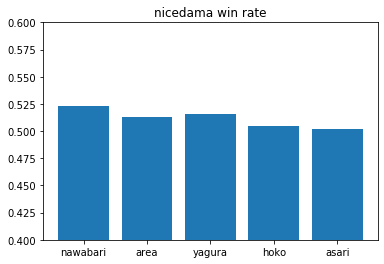

In [13]:
nawabari_win_rate = win_rate_special_mode_df[win_rate_special_mode_df['nawabari_special'] == 'nicedama']['nawabari_win_rate'].values[0]
area_win_rate = win_rate_special_mode_df[win_rate_special_mode_df['area_special'] == 'nicedama']['area_win_rate'].values[0]
yagura_win_rate = win_rate_special_mode_df[win_rate_special_mode_df['yagura_special'] == 'nicedama']['yagura_win_rate'].values[0]
hoko_win_rate = win_rate_special_mode_df[win_rate_special_mode_df['hoko_special'] == 'nicedama']['hoko_win_rate'].values[0]
asari_win_rate = win_rate_special_mode_df[win_rate_special_mode_df['asari_special'] == 'nicedama']['asari_win_rate'].values[0]
plt.bar(['nawabari', 'area', 'yagura', 'hoko', 'asari'],[nawabari_win_rate, area_win_rate, yagura_win_rate, hoko_win_rate, asari_win_rate])
plt.ylim(0.4, 0.6) ,plt.title('nicedama win rate');

ヤグラでの勝率1位はやはりナイス玉でした。  
ただ、ヤグラ、アサリは他のルールに比べてスペシャルによる勝率の違いは少ないようです。  
ナイス玉はナワバリやエリアでも強いことがわかります。

# 【検証5】ウルトラハンコはホコに強く、ヤグラに弱い？？
ウルトラハンコは発動すると巨大なハンコを地面に打ち付けながら進むスペシャルのため、ヤグラへの干渉が難しく弱いと言われています。  
ホコではホコバリアを一瞬で割れたり、ホコが進む道を作ったりとウルトラハンコがあると非常に助かる場面が多い印象です。

Text(0.5, 1.0, 'ultrahanko win rate')

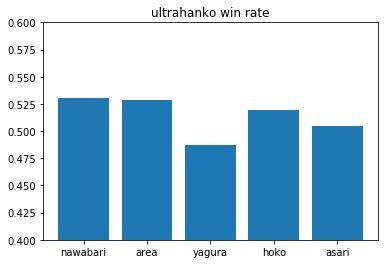

In [14]:
nawabari_win_rate = win_rate_special_mode_df[win_rate_special_mode_df['nawabari_special'] == 'ultrahanko']['nawabari_win_rate'].values[0]
area_win_rate = win_rate_special_mode_df[win_rate_special_mode_df['area_special'] == 'ultrahanko']['area_win_rate'].values[0]
yagura_win_rate = win_rate_special_mode_df[win_rate_special_mode_df['yagura_special'] == 'ultrahanko']['yagura_win_rate'].values[0]
hoko_win_rate = win_rate_special_mode_df[win_rate_special_mode_df['hoko_special'] == 'ultrahanko']['hoko_win_rate'].values[0]
asari_win_rate = win_rate_special_mode_df[win_rate_special_mode_df['asari_special'] == 'ultrahanko']['asari_win_rate'].values[0]
plt.bar(['nawabari', 'area', 'yagura', 'hoko', 'asari'],[nawabari_win_rate, area_win_rate, yagura_win_rate, hoko_win_rate, asari_win_rate])
plt.ylim(0.4, 0.6)
plt.title('ultrahanko win rate')

本当にヤグラに弱かったですね。ちょっとびっくりしました。  
ホコは2位でやはり強いようですが、ナワバリやエリアでも強さを見せます。

## 【検証6】 インクアーマー二枚編成は強い？？
インクアーマーとは発動すると自分と味方全員にインクのアーマーをまとわせます。  
アーマーは30のダメージを受けると消滅します。  
ガチマッチに潜ってアーマー2枚編成だとうまくアーマーが回って強いような気がしているので、検証してみます。  
3枚以上だと、発動の被りなどがあってイマイチな気がしていますが、どうでしょうか。  
インクアーマーがある場合の平均勝率は0.506です。

In [15]:
def win_rate_special_count(special, special_count, df):
    count = (len(df[df[special + '_A'] == special_count]) + len(df[df[special + '_B'] == special_count])) # それぞれのチームで対象スペシャルが出現する試合数のカウント
    win = (len(df[(df[special + '_A'] == special_count) & (df.y == 1)]) +len((df[(df[special + '_B'] == special_count) & (df.y == 0)]))) # それぞれのチームで対象スペシャルが出現する試合のうち各チームが勝利する試合数のカウント
    rate = win / count
    return rate, count

win_rate_special_df = []
special = 'armor'
for armor_count in range(1, 5):
    rate, count = win_rate_special_count(special, armor_count, train)
    win_rate_special_df.append([special, armor_count, rate, count])
win_rate_special_df = pd.DataFrame(win_rate_special_df, columns=['special','armor_count', 'win_rate', 'count'])
win_rate_special_df = win_rate_special_df.sort_values(by= 'win_rate', ascending=False)
win_rate_special_df = win_rate_special_df.reset_index(drop=True)

display(win_rate_special_df)

,special,armor_count,win_rate,count
0,armor,2,0.521613,8629
1,armor,3,0.516502,606
2,armor,1,0.506356,45156
3,armor,4,0.125000,16


仮説通りインクアーマー二枚が最も勝率が高いことがわかりました。

# 【検証7】 長射程有利のステージがあるって本当？？
見晴らしが良かったり、高台が存在するステージ(アロワナモール、デボン海洋博物館、ホテルニューオートロ、モンガラキャンプ場など)では長射程が有利だと言われていますが、本当でしょうか。  
今回はチャージャー種、スピナー種を長射程とします。(ジェットスイーパーも長いけど若干役割が違いそうので今回は除外)

In [16]:
cols = ['A1-weapon', 'A2-weapon', 'A3-weapon', 'A4-weapon', 'B1-weapon', 'B2-weapon', 'B3-weapon', 'B4-weapon']
for col in cols:
    train = train.merge(buki_data[['key','category2']], left_on=col, right_on='key', how='left').drop(columns='key').rename(columns={'category2':'category2' + '_' + col})

In [17]:
def category2_count(df):
    df_A = df[['category2_A1-weapon', 'category2_A2-weapon', 'category2_A3-weapon', 'category2_A4-weapon']].values
    df_B = df[['category2_B1-weapon', 'category2_B2-weapon', 'category2_B3-weapon', 'category2_B4-weapon']].values
    A_category2 = pd.DataFrame([Counter(x) for x in df_A]).fillna(0).astype('int8')
    B_category2 = pd.DataFrame([Counter(x) for x in df_B]).fillna(0).astype('int8')
    A_category2 = A_category2.add_suffix('_A')
    B_category2 = B_category2.add_suffix('_B')
    X = pd.concat([A_category2, B_category2], axis=1)
    return X
X = category2_count(train)
train = pd.concat([train, X], axis=1)

In [18]:
def win_rate_category2(category2, df):
    count = (len(df[df[category2 + '_A'] != 0]) + len(df[df[category2 + '_B'] != 0])) # それぞれのチームで対象カテゴリーが出現する試合数のカウント
    win = (len(df[(df[category2 + '_A'] != 0) & (df.y == 1)]) +len((df[(df[category2 + '_B'] != 0) & (df.y == 0)]))) # それぞれのチームで対象カテゴリーが出現する試合のうち各チームが勝利する試合数のカウント
    rate = win / count
    return rate, count

win_rate_category2_df = []
for category2 in buki_data.category2.unique():
    rate, count = win_rate_category2(category2, train)
    win_rate_category2_df.append([category2, rate, count])
win_rate_category2_df = pd.DataFrame(win_rate_category2_df, columns=['category2', 'win_rate', 'count'])
win_rate_category2_df = win_rate_category2_df.sort_values(by= 'win_rate', ascending=False)
win_rate_category2_df = win_rate_category2_df.reset_index(drop=True)

display(win_rate_category2_df)

,category2,win_rate,count
0,reelgun,0.518663,17655
1,roller,0.505559,49112
2,maneuver_cat,0.505459,60266
3,brella,0.505192,11556
4,slosher,0.504853,37607
5,splatling,0.503284,38672
6,shooter,0.502101,117345
7,brush,0.500111,18098
8,blaster,0.485802,27680
9,charger,0.467741,46560


チャージャー種の平均勝率は0.475、スピナー種の勝率は0.505

In [19]:
win_rate_charger_df = []
category2 = 'charger'
print('Charger win rate by stage\n')
for stage in train.stage.unique():
    df = train[train['stage'] == stage] 
    rate, count = win_rate_category2(category2, df)
    win_rate_charger_df.append([stage, rate, count])
win_rate_charger_df = pd.DataFrame(win_rate_charger_df, columns=['category2', 'win_rate', 'count'])
win_rate_charger_df = win_rate_charger_df.sort_values(by= 'win_rate', ascending=False)
win_rate_charger_df = win_rate_charger_df.reset_index(drop=True)
win_rate_charger_df

Charger win rate by stage



,category2,win_rate,count
0,devon,0.481410,2071
1,tachiuo,0.479608,1839
2,kombu,0.476865,2118
3,mongara,0.475717,1709
4,otoro,0.474598,1555
5,mutsugoro,0.473930,2359
6,fujitsubo,0.471385,1625
7,mozuku,0.471097,1851
8,zatou,0.469971,2381
9,chozame,0.469855,2488


In [20]:
win_rate_charger_df = []
category2 = 'splatling'
print('Splatling win rate by stage\n')
for stage in train.stage.unique():
    df = train[train['stage'] == stage] 
    rate, count = win_rate_category2(category2, df)
    win_rate_charger_df.append([stage, rate, count])
win_rate_charger_df = pd.DataFrame(win_rate_charger_df, columns=['category2', 'win_rate', 'count'])
win_rate_charger_df = win_rate_charger_df.sort_values(by= 'win_rate', ascending=False)
win_rate_charger_df = win_rate_charger_df.reset_index(drop=True)
win_rate_charger_df

Splatling win rate by stage



,category2,win_rate,count
0,hakofugu,0.528805,1649
1,sumeshi,0.528481,1896
2,otoro,0.527821,1294
3,mozuku,0.522770,1603
4,ajifry,0.518659,1581
5,arowana,0.516304,1656
6,devon,0.511758,1786
7,engawa,0.507285,1510
8,mongara,0.506980,1361
9,hokke,0.506321,1661


チャージャー種の勝率が高いのはデボン海洋博物館、タチウオパーキング、コンブトラック、モンガラキャンプ場、ホテルニューオートロ、  
スピナー種の勝率が高いのはハコフグ倉庫、スメーシーワールド、ホテルニューオートロ、モズク農園、アジフライスタジアムとなりました。  
筆者の経験則とは少しズレますが、ある程度納得のいく結果のようにも見えます。  

チャージャーでは平均と比較して勝率の高いタチウオパーキングが、スピナーでは最も勝率が低くなっているのが面白いです。  
長射程といってもステージごとの勝ちやすさの違いがあるようです。筆者はどちらも使ったことがないのでよくわかりません。  

スピナー種はチャージャー種に比べて、ステージごとの勝率の差が大きいのも面白い発見だと思います。  
スピナー種 : 0.475～0.528  
チャージャー種: 0.453～0.481  
  
他のブキもステージごとの勝率を見てみるといろいろ面白いと思います。

# 【検証8】 チャージャー二枚編成は弱い？？
筆者は自分のチームにチャージャー二枚がくると負けることが多いような気がしています。実際のところどうなのか検証してみます。

In [21]:
def win_rate_category2_count(category2, category2_count, df):
    count = (len(df[df[category2 + '_A'] == category2_count]) + len(df[df[category2 + '_B'] == category2_count])) # それぞれのチームで対象カテゴリーが出現する試合数のカウント
    win = (len(df[(df[category2 + '_A'] == category2_count) & (df.y == 1)]) +len((df[(df[category2 + '_B'] == category2_count) & (df.y == 0)]))) # それぞれのチームで対象カテゴリーが出現する試合のうち各チームが勝利する試合数のカウント
    rate = win / count
    return rate, count

In [22]:
win_rate_category2_df = []
category2 = 'charger'
for category2_count in range(1, 5):
    rate, count = win_rate_category2_count(category2, category2_count, train)
    win_rate_category2_df.append([category2, category2_count, rate, count])
win_rate_category2_df = pd.DataFrame(win_rate_category2_df, columns=['category2','category2_count', 'win_rate', 'count'])
win_rate_category2_df = win_rate_category2_df.sort_values(by= 'win_rate', ascending=False)
win_rate_category2_df = win_rate_category2_df.reset_index(drop=True)

display(win_rate_category2_df)

,category2,category2_count,win_rate,count
0,charger,1,0.474648,42029
1,charger,2,0.412467,4187
2,charger,3,0.297297,333
3,charger,4,0.272727,11


仮説通りチャージャー二枚編成は勝率が低いようです。

# 最後に
ルールやステージにより勝ちやすいブキやスペシャルは確かに存在しそうです。  
今回やらなかったこととして、ブキの組み合わせやウデマエ(C-~X)別でのブキの勝率の違いなども参考になるかもしれません。  